In [15]:
import pandas as pd
import tensorflow as tf
import numpy as np
import scipy.io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from keras.layers.core import Dense, Activation

In [16]:
df = pd.read_csv(r'c:\Users\Dataset.csv', index_col=None, na_values=['NA'], sep=',', low_memory=False)

In [17]:
#Convert Malicious packets into true and Benign into false

df['target'] = df[' Label'] != 'BENIGN'
df = df.drop(' Label', axis=1)
df = df.replace(['Infinity'], np.nan)


In [18]:
#cleaning up data and dropping NaN and Infinity Values
df = df.dropna()
assert pd.isnull(df).sum().sum() == 0 
assert pd.isna(df).sum().sum() == 0

#Replace NaN and infinity values 
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace(np.nan, 0)
df.replace(np.nan, 0, inplace=True)

In [19]:
#Split Features 
x = df.drop('target', axis=1)
y = df[['target']]

In [20]:
#Scale the data using Standard scaler with Mean = 0 and SD = 1

# Get column names from features
col_names = x.columns
# Creating Scaler object
scaler_object = preprocessing.StandardScaler()
# Fit data within the scaler object
scaled_df = scaler_object.fit_transform(x)
scaled_df = pd.DataFrame(scaled_df, columns=col_names)

# concat into x feature 
x = pd.DataFrame(scaled_df)

x[0:5]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.356380,-0.654735,-0.011460,-0.009372,-0.089171,-0.007588,-0.377384,-0.177020,-0.346490,-0.366976,...,-0.008567,-1.068350,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.57149
1,-0.336726,-0.655620,0.001911,-0.005312,-0.062264,-0.007446,-0.256570,-0.294406,-0.285411,-0.228011,...,-0.002979,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.57149
2,-0.355871,-0.655605,0.000574,-0.004297,0.420442,-0.006187,2.219292,-0.294406,1.612049,2.428138,...,-0.004376,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.57149
3,-0.336726,-0.655275,0.009934,0.001794,0.469393,-0.004622,1.785685,-0.294406,0.902531,1.514421,...,0.005403,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.57149
4,-0.355871,-0.655605,-0.000763,-0.004297,0.420442,-0.006186,2.219292,-0.294406,1.833890,2.701870,...,-0.005773,0.829301,-0.131771,-0.100491,-0.148812,-0.104465,-0.580707,-0.105787,-0.585977,-0.57149


In [21]:
# Turn Outcomes into dummy variables 

dummies = pd.get_dummies(y['target'])

# This will turn BENIGN values into 1 being False and all malicious packets into 0 being True. 
y = dummies.values

print(y)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [22]:
#Perform PCA on the feature vector to get a more precise accuracy on the dataset. Rescale from 78 features to 2 features.

pca=PCA(n_components = 2)
pca.fit(x)
x_pca = pca.transform(x)
print ("original shape:   ", x.shape)
print ("transformed shape:",x_pca.shape)

x = x_pca

original shape:    (691406, 78)
transformed shape: (691406, 2)


In [23]:
#Split into test and training sets. 25% test sample 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)

In [45]:
# Create Neural Network, with 3 hidden layers and 1 output layer being subjected to the softmax probability function

model = Sequential()

model.add(Dense(160, input_dim = x.shape[1], activation='relu', kernel_initializer='normal'))
model.add(Dense(100, input_dim = x.shape[1], activation='relu', kernel_initializer='normal', )) 
model.add(Dense(50, input_dim = x.shape[1],  activation='relu', kernel_initializer='normal',)) 
model.add(Dense(y.shape[1],activation='softmax')) #takes in an input and spits out 1D vector

#Add in hyper parameters
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
#Early stopping used to stop model from over or under fitting - stops when accuracy is no longer improving 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6, verbose=3, mode='auto', restore_best_weights=False, baseline=None)
#Fit the model
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=100)

Train on 518554 samples, validate on 172852 samples
Epoch 1/100
518554/518554 [==============================] - 58s 111us/step - loss: 0.1766 - acc: 0.9234 - val_loss: 0.1786 - val_acc: 0.9486
Epoch 2/100
518554/518554 [==============================] - 28s 54us/step - loss: 0.1281 - acc: 0.9452 - val_loss: 0.1076 - val_acc: 0.9640
Epoch 3/100
518554/518554 [==============================] - 29s 55us/step - loss: 0.1119 - acc: 0.9547 - val_loss: 0.0988 - val_acc: 0.9664
Epoch 4/100
518554/518554 [==============================] - 24s 45us/step - loss: 0.1058 - acc: 0.9584 - val_loss: 0.1044 - val_acc: 0.9589
Epoch 5/100
518554/518554 [==============================] - 24s 45us/step - loss: 0.1010 - acc: 0.9600 - val_loss: 0.0940 - val_acc: 0.9654
Epoch 6/100
518554/518554 [==============================] - 23s 45us/step - loss: 0.0961 - acc: 0.9629 - val_loss: 0.0890 - val_acc: 0.9666
Epoch 7/100
518554/518554 [==============================] - 24s 46us/step - loss: 0.0931 - acc: 0.96

In [46]:
# Measure accuracy
predictors = model.predict(x_test)
predictors = np.argmax(predictors,axis=1)
prediction = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(prediction, predictors)
print("Accuracy:", score * 100,"%")

Accuracy: 97.09983106935412 %


In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(prediction,predictors)

# 106769 = TP (True Positive)
# 61070 = TN (True Negative)
# 3122 = FP (False Positive)
# 1891 = FN (False Negative)

array([[106769,   3122],
       [  1891,  61070]], dtype=int64)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(prediction,predictors)) 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    109891
           1       0.95      0.97      0.96     62961

    accuracy                           0.97    172852
   macro avg       0.97      0.97      0.97    172852
weighted avg       0.97      0.97      0.97    172852



In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(prediction,predictors)

In [50]:
#Precision

precision

array([0.36424803, 0.95136466, 1.        ])

In [51]:
#Recall 

recall

array([1.        , 0.96996553, 0.        ])

In [52]:
#F1 Score 

from sklearn.metrics import f1_score
f1 = f1_score(prediction,predictors)

f1

0.9605750552484015

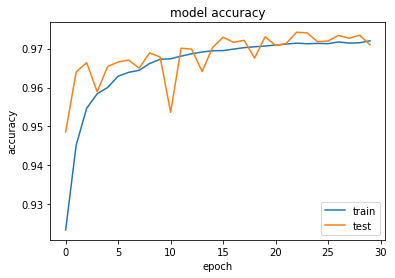

In [58]:
# plot training history
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#show in the graph below the acurracy on both the trained and validated
#has a ever so slight increase, meaning the model could be trained longer
#to increase the accuracy of the model.It can also be seen that the model
#has not been over or under fitted as both show some comparable skill.

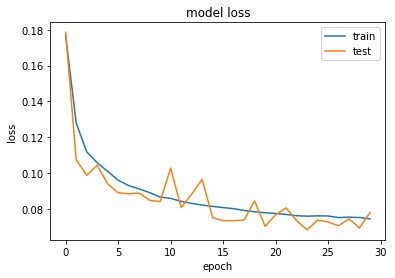

In [61]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#shown from the graph below both have comparable performance within the 
#trained and validated dataset.If the plots start to depart ways it could
#be a sign to stop the model at an ealier epoch. 